<a href="https://colab.research.google.com/github/hasibzunair/sharp-unets/blob/master/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Biomedical Image segmentation with Sharp U-Net

**Author:** [Hasib Zunair](https://twitter.com/hasibzunair)<br>
**Date created:** 2021/09/01<br>
**Last modified:** 2021/09/01<br>
**Description:** Sharp U-Net model trained from scratch on the ISIC-2017 Skin lesion segmentation dataset.

# Setup environment

## Install Python 3.6

In [ ]:
%%bash

MINICONDA_INSTALLER_SCRIPT=Miniconda3-4.5.4-Linux-x86_64.sh
MINICONDA_PREFIX=/usr/local
wget https://repo.continuum.io/miniconda/$MINICONDA_INSTALLER_SCRIPT
chmod +x $MINICONDA_INSTALLER_SCRIPT
./$MINICONDA_INSTALLER_SCRIPT -b -f -p $MINICONDA_PREFIX

In [ ]:
import sys
_ = (sys.path.append("/usr/local/lib/python3.6/site-packages"))

In [ ]:
# Check python version, should be 3.6.5
!python --version

Python 3.6.5 :: Anaconda, Inc.


## Install Keras and TensorFlow

Restart runtime after running this cell.

In [ ]:
!pip install -U --pre tensorflow=="2.0.0a0"
!pip install q keras=="2.3.1"

## Import libraries

In [ ]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import keras

from keras.optimizers import *
from keras.layers import * 
from keras.models import Model
from keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, ReduceLROnPlateau
from keras import backend as K
from tqdm import tqdm
from sklearn.model_selection import train_test_split

# Download data

Here, we download the image data and the corresponding ground truth segmentation masks.

In the paper we did not use the ISIC-17 Dataset, which will be used here for the demo.

## Downloading the Images
Please note that the links may be different when you are running this notebook. Please update the link accordingly

In [ ]:
! wget "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip" -O ISIC_2017_images.zip

--2021-08-19 06:23:41--  https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Data.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.216.138.12
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.216.138.12|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6229496702 (5.8G) [application/zip]
Saving to: ‘ISIC_2017_images.zip’

ISIC_2017_images.zi 100%[===================>]   5.80G  44.0MB/s    in 2m 41s  

2021-08-19 06:26:22 (37.0 MB/s) - ‘ISIC_2017_images.zip’ saved [6229496702/6229496702]



## Downloading the Ground Truth Segmentation
Please note that the links may be different when you are running this notebook. Please update the link accordingly

In [ ]:
! wget "https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip" -O ISIC_2017_masks.zip

--2021-08-19 06:26:22--  https://isic-challenge-data.s3.amazonaws.com/2017/ISIC-2017_Training_Part1_GroundTruth.zip
Resolving isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)... 52.217.197.209
Connecting to isic-challenge-data.s3.amazonaws.com (isic-challenge-data.s3.amazonaws.com)|52.217.197.209|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 9321981 (8.9M) [application/zip]
Saving to: ‘ISIC_2017_masks.zip’

ISIC_2017_masks.zip 100%[===================>]   8.89M  13.2MB/s    in 0.7s    

2021-08-19 06:26:23 (13.2 MB/s) - ‘ISIC_2017_masks.zip’ saved [9321981/9321981]




# Extracting the Zip Files
Next the downloaded zip files are unzipped and the data is extracted

In [ ]:
! unzip ISIC_2017_images.zip -d ISIC_2017_images
! unzip ISIC_2017_masks.zip -d ISIC_2017_masks

# Build Training and Test Datasets
## Loading the Images
We first load all the images and the corresponding segmentation masks.

They are stored in two lists X, Y and respectively

Moreover, the images are resized to 256x192

In [ ]:
img_files = next(os.walk('ISIC_2017_images/ISIC-2017_Training_Data'))[2]
msk_files = next(os.walk('ISIC_2017_masks/ISIC-2017_Training_Part1_GroundTruth'))[2]

img_files.sort()
msk_files.sort()

print(len(img_files))
print(len(msk_files))

X = []
Y = []

for img_fl in tqdm(img_files):    
    if(img_fl.split('.')[-1]=='jpg'):
        img = cv2.imread('ISIC_2017_images/ISIC-2017_Training_Data/{}'.format(img_fl))
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        resized_img = cv2.resize(img,(256, 192), interpolation = cv2.INTER_CUBIC)
        X.append(resized_img)
        
        msk = cv2.imread('ISIC_2017_masks/ISIC-2017_Training_Part1_GroundTruth/{}'.format(img_fl.split('.')[0]+'_segmentation.png'),cv2.IMREAD_GRAYSCALE)
        resized_msk = cv2.resize(msk,(256, 192), interpolation = cv2.INTER_CUBIC)
        Y.append(resized_msk)

4001
2000


100%|██████████| 4001/4001 [04:52<00:00, 13.70it/s]



#Train-Test Split
The X, Y lists are converted to numpy arrays for convenience. Furthermore, the images are divided by 255 to bring down the pixel values to [0...1] range. On the other hand the segmentations masks are converted to binary (0 or 1) values.

Using Sklearn train_test_split we split the data randomly into 80% training and 20% testing data

In [ ]:
print(len(X))
print(len(Y))

X = np.array(X)
Y = np.array(Y)

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=0)

Y_train = Y_train.reshape((Y_train.shape[0],Y_train.shape[1],Y_train.shape[2],1))
Y_test = Y_test.reshape((Y_test.shape[0],Y_test.shape[1],Y_test.shape[2],1))

X_train = X_train / 255
X_test = X_test / 255
Y_train = Y_train / 255
Y_test = Y_test / 255

Y_train = np.round(Y_train,0)	
Y_test = np.round(Y_test,0)	

print(X_train.shape)
print(Y_train.shape)
print(X_test.shape)
print(Y_test.shape)

2000
2000
(1600, 192, 256, 3)
(1600, 192, 256, 1)
(400, 192, 256, 3)
(400, 192, 256, 1)


# Prepare the Sharp U-Net model

Sharp U-Net paper: https://arxiv.org/abs/2107.12461

## Build sharp blocks

In [ ]:
def get_kernel():
    """
    See https://setosa.io/ev/image-kernels/
    """

    k1 = np.array([[0.0625, 0.125, 0.0625],
                   [0.125,  0.25, 0.125],
                   [0.0625, 0.125, 0.0625]])
    
    # Sharpening Spatial Kernel, used in paper
    k2 = np.array([[-1, -1, -1],
                   [-1,  8, -1],
                   [-1, -1, -1]])
    
    k3 = np.array([[0, -1, 0],
                   [-1,  5, -1],
                   [0, -1, 0]])
    
    return k1, k2, k3


def build_sharp_blocks(layer):
    """
    Sharp Blocks
    """
    # Get number of channels in the feature
    in_channels = layer.shape[-1]
    # Get kernel
    _, w, _ = get_kernel()    
    # Change dimension
    w = np.expand_dims(w, axis=-1)
    # Repeat filter by in_channels times to get (H, W, in_channels)
    w = np.repeat(w, in_channels, axis=-1)
    # Expand dimension
    w = np.expand_dims(w, axis=-1)
    return w


## Build the Sharp U-Net model

In [ ]:
def SharpUNet(img_size, num_classes):
    "Unet with sharp Blocks in skip connections"

    # Kernel size for sharp blocks
    kernel_size = 3

    inputs = Input(img_size)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(inputs)
    conv1 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1)
    pool1 = MaxPooling2D(pool_size=(2, 2))(conv1)

    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(pool1)
    conv2 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv2)
    pool2 = MaxPooling2D(pool_size=(2, 2))(conv2)

    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(pool2)
    conv3 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv3)
    pool3 = MaxPooling2D(pool_size=(2, 2))(conv3)

    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(pool3)
    conv4 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv4)
    pool4 = MaxPooling2D(pool_size=(2, 2))(conv4)

    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(pool4)
    conv5 = Conv2D(512, (3, 3), activation='relu', padding='same')(conv5)
    
    # Skip connection 1
    # 1. Get sharpening kernel weights(1, H, W, channels) 
    W1 = build_sharp_blocks(conv4)
    # 2. Build depthwise convolutional layer with random weights
    sb1 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    # 3. Pass input to layer
    conv4 = sb1(conv4)
    # 4. Set filters as layer weights 
    sb1.set_weights([W1])
    # 5. Dont update weights
    sb1.trainable = False
    
    up6 = concatenate([Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(conv5), conv4], axis=3)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(up6)
    conv6 = Conv2D(256, (3, 3), activation='relu', padding='same')(conv6)
    
    # Skip connection 2
    W2 = build_sharp_blocks(conv3) 
    sb2 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv3 = sb2(conv3)
    sb2.set_weights([W2])
    sb2.trainable = False
   
    up7 = concatenate([Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(conv6), conv3], axis=3)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(up7)
    conv7 = Conv2D(128, (3, 3), activation='relu', padding='same')(conv7)

    # Skip connection 3
    W3 = build_sharp_blocks(conv2) 
    sb3 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv2 = sb3(conv2)
    sb3.set_weights([W3])
    sb3.trainable = False
    
    
    up8 = concatenate([Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(conv7), conv2], axis=3)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(up8)
    conv8 = Conv2D(64, (3, 3), activation='relu', padding='same')(conv8)
    
    
    # Skip connection 4
    W4 = build_sharp_blocks(conv1)
    sb4 = DepthwiseConv2D(kernel_size, use_bias=False, padding='same')
    conv1 = sb4(conv1)
    sb4.set_weights([W4])
    sb4.trainable = False
    

    up9 = concatenate([Conv2DTranspose(32, (2, 2), strides=(2, 2), padding='same')(conv8), conv1], axis=3)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(up9)
    conv9 = Conv2D(32, (3, 3), activation='relu', padding='same')(conv9)

    # for multi-class segmentation, use the 'softmax' activation
    conv10 = Conv2D(num_classes, (1, 1), activation='sigmoid')(conv9)

    model = Model(inputs=[inputs], outputs=[conv10])    
    
    return model


#Other Functions
## Custom Metrics
Since Keras does not have build-in support for computing Dice Coefficient or Jaccard Index (at the time of writing), the following functions are declared

In [ ]:
smooth = 1

def jacard(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum ( y_true_f * y_pred_f)
    union = K.sum ( y_true_f + y_pred_f - y_true_f * y_pred_f)
    return intersection/union


def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

## Model callbacks

In [ ]:
checkpointer = ModelCheckpoint("model.h5", verbose=0, monitor='val_loss', mode='min', save_best_only=True)
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.1, patience=10, verbose=1, min_lr=1e-8, mode='min')
early_stopping = EarlyStopping(monitor='val_loss', min_delta=0, verbose=1, patience=10, mode='min', restore_best_weights=True)

# Build, compile and train the model

In [ ]:
# Free up RAM in case the model definition cells were run multiple times
keras.backend.clear_session()

# Build model
model = None
model = SharpUNet((192,256,3), 1)
model.summary()

# Compile model
model.compile(optimizer = 'adam', loss = 'binary_crossentropy',
              metrics = [jacard, dice_coef])

# Train
epochs = 10000
model.fit(X_train, Y_train,
                batch_size=16,
                epochs=epochs,
                validation_data=(X_test, Y_test),
                callbacks=[early_stopping, reduce_lr, checkpointer],
                shuffle=True)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 192, 256, 3) 0                                            
__________________________________________________________________________________________________
conv2d (Conv2D)                 (None, 192, 256, 32) 896         input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 192, 256, 32) 9248        conv2d[0][0]                     
__________________________________________________________________________________________________
max_pooling2d (MaxPooling2D)    (None, 96, 128, 32)  0           conv2d_1[0][0]                   
______________________________________________________________________________________________

# Evaluate

In [ ]:
# Evaluate trained model using Jaccard and Dice metric
yp = None
yp = model.predict(x=X_test, batch_size=16, verbose=0)
#Round off boolean masks
yp = np.round(yp,0) 

jacard = 0
dice = 0

for i in range(len(Y_test)):
    yp_2 = yp[i].ravel()
    y2 = Y_test[i].ravel()
    intersection = yp_2 * y2
    union = yp_2 + y2 - intersection
    jacard += (np.sum(intersection)/np.sum(union))  
    dice += (2. * np.sum(intersection) ) / (np.sum(yp_2) + np.sum(y2))

jacard /= len(Y_test)
dice /= len(Y_test)

print('Jacard Index : '+str(jacard))
print('Dice Coefficient : '+str(dice))

Jacard Index : 0.8155585919113507
Dice Coefficient : 0.8871696625850256


### Visualize predictions

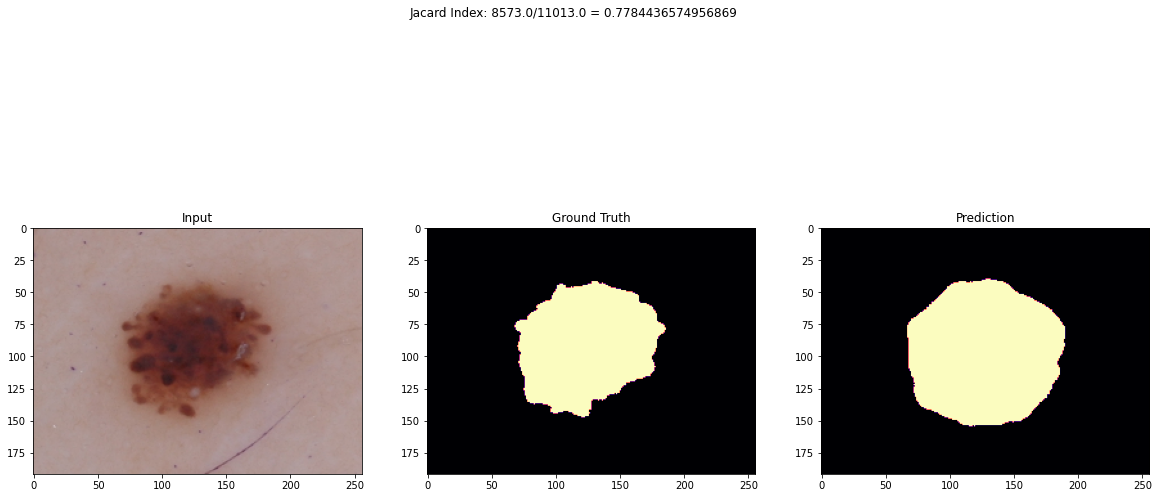

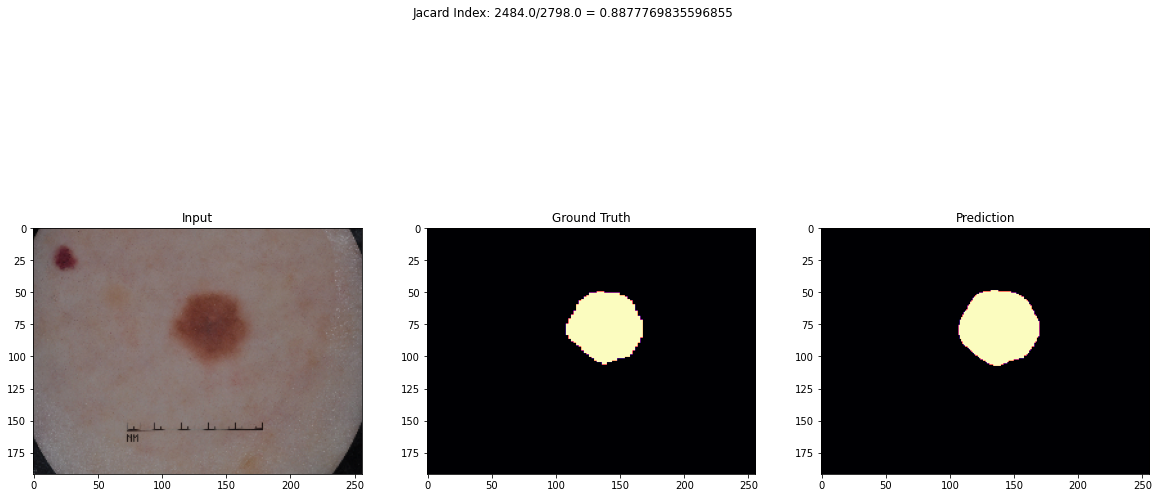

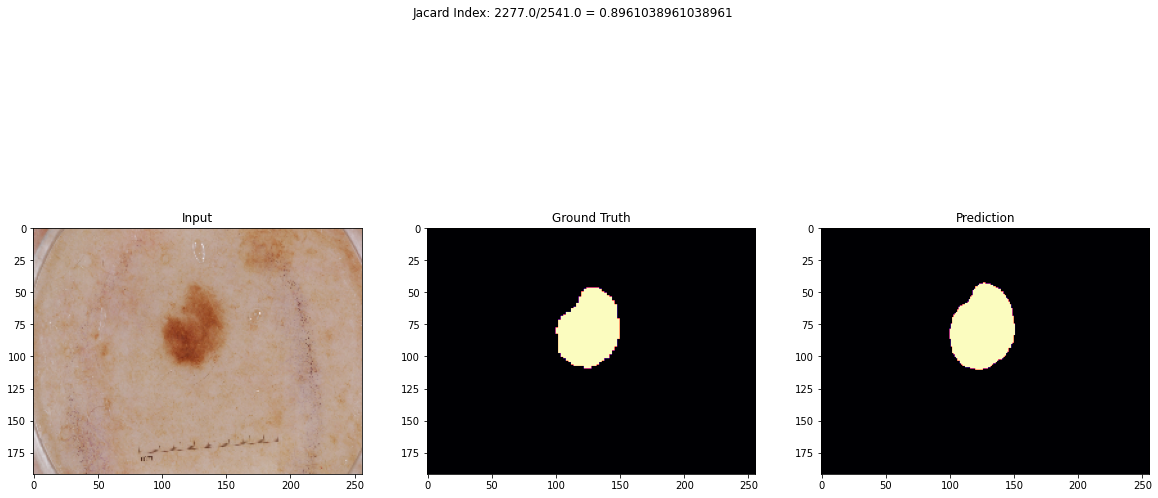

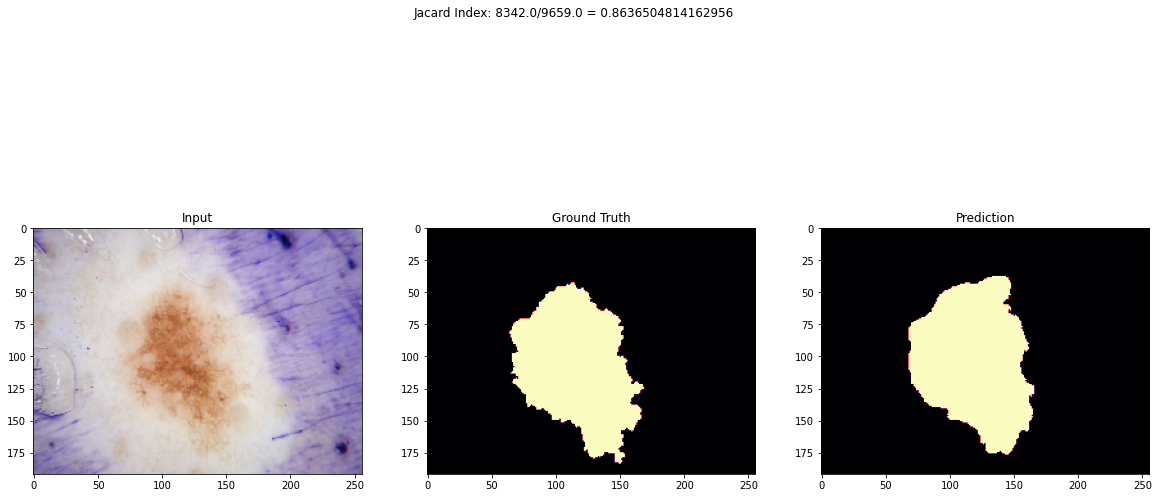

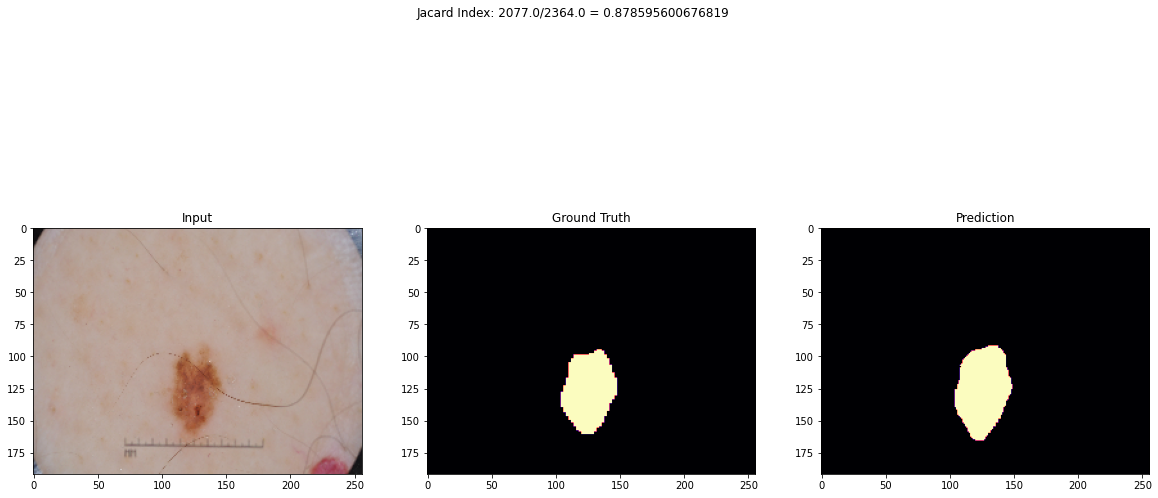

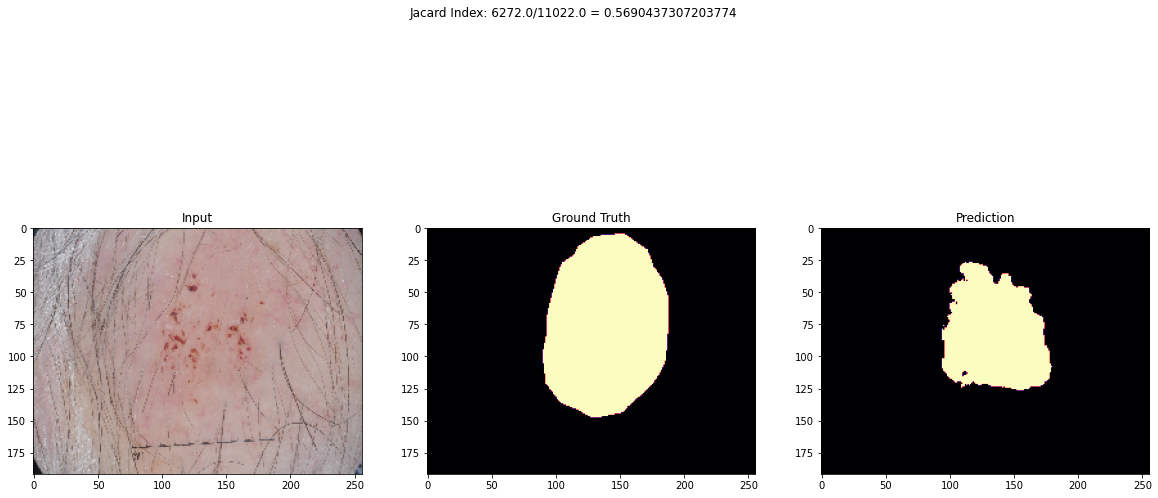

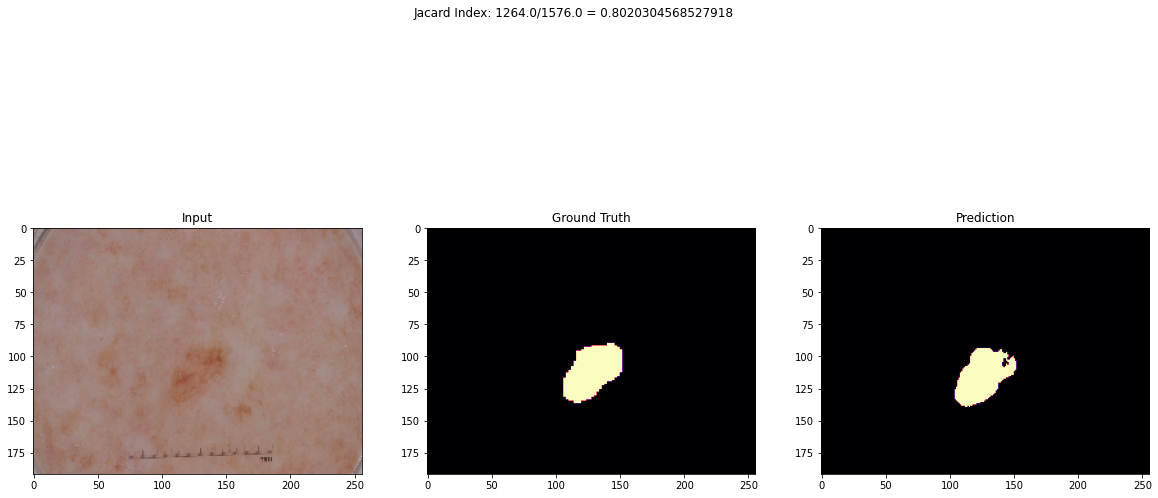

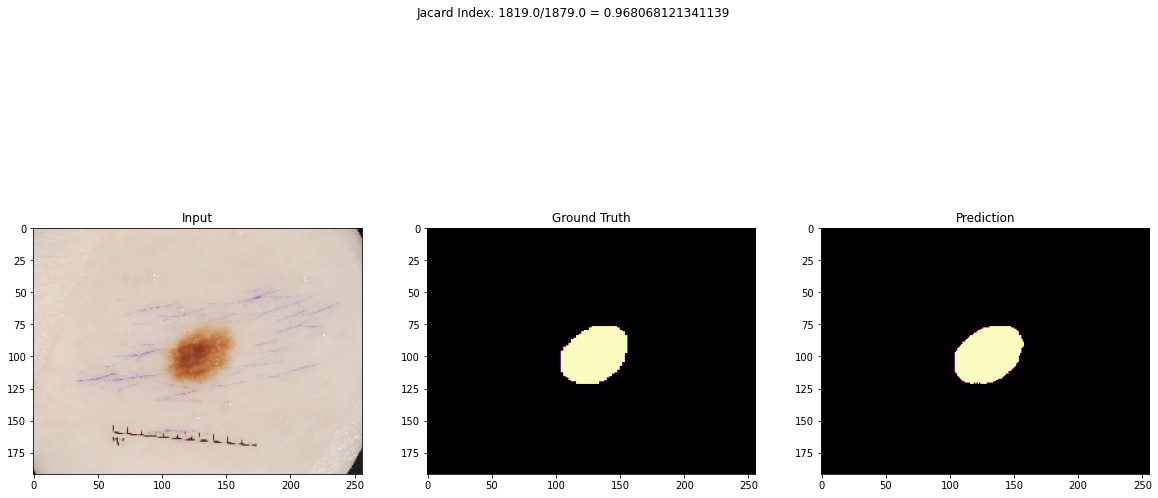

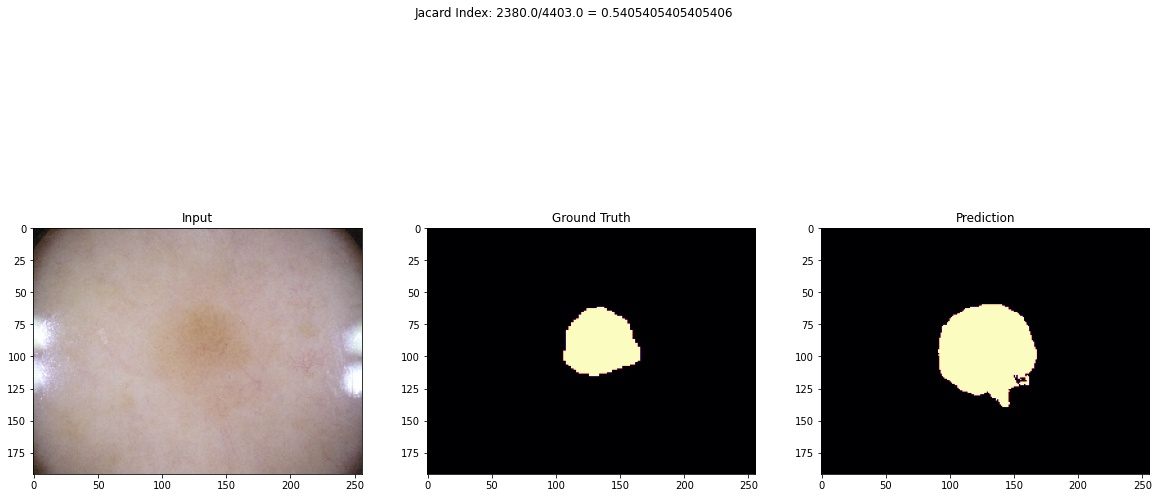

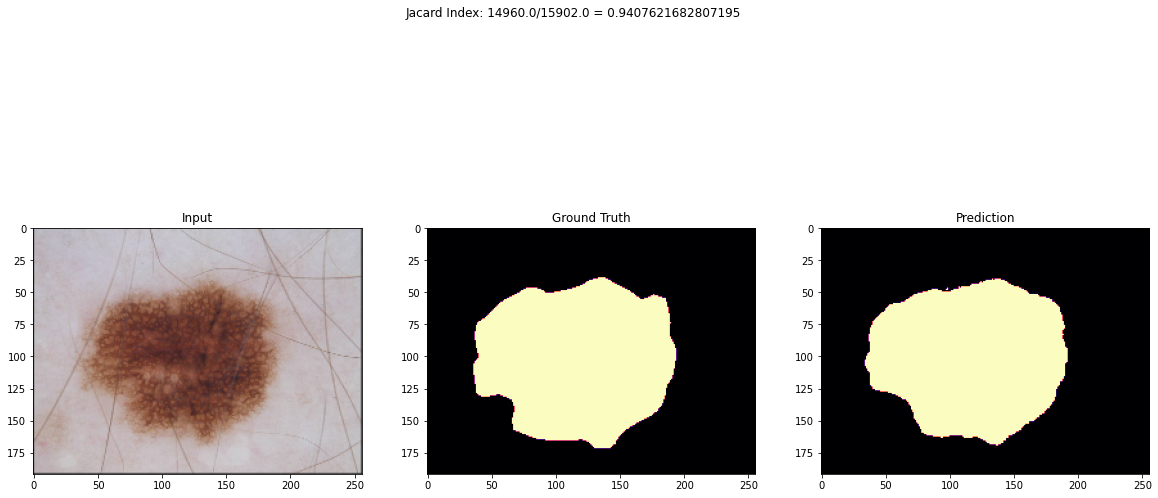

In [ ]:
for i in range(10):
    plt.figure(figsize=(20,10))
    plt.subplot(1,3,1)
    if len(X_test[i].shape) >= 2:
        plt.grid(False)
        plt.imshow(X_test[i].squeeze(), cmap='gray') # 1-channel image
    else:
        plt.grid(False)
        plt.imshow(X_test[i]) # 3-channel
        
    plt.title('Input')
    plt.subplot(1,3,2)
    plt.grid(False)
    plt.imshow(Y_test[i].reshape(Y_test[i].shape[0],Y_test[i].shape[1]), cmap='magma') #cmap='magma'
    plt.title('Ground Truth')
    plt.subplot(1,3,3)
    plt.grid(False)
    plt.imshow(yp[i].reshape(yp[i].shape[0],yp[i].shape[1]),cmap='magma')
    plt.title('Prediction')
    
    # Calc jaccard index of predictions
    intersection = yp[i].ravel() * Y_test[i].ravel()
    union = yp[i].ravel() + Y_test[i].ravel() - intersection
    jacard = (np.sum(intersection)/np.sum(union))  
    
    plt.suptitle('Jacard Index: '+ str(np.sum(intersection)) +'/'+ str(np.sum(union)) +' = '+str(jacard))
    plt.show()
    plt.close()

# Acknowledgements

Demo notebook style was taken from [this](https://github.com/nibtehaz/MultiResUNet) repository.